<h1>Here we will do the second step for the evolution for binaries that result in WD-WD pairs</h1> 

<p>Written by Nadia Zakamska June 2024, updated July 2025</p>

<p>The approach is the same as in the public_evolution code which tackles the first step of the binary evolution.</p>

In [1]:
# library imports
import numpy as np
from matplotlib import pyplot as plt
import sys
from astropy.table import Table
from astropy.io import fits
from scipy.integrate import solve_ivp
from scipy import interpolate
import time
# this is the library of helper functions provided separately, should be in the same folder as the notebook
import orbital

###Plot formatting commands
plt.rc('figure', figsize=(6,5)) 
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands

<h1>Some important model parameters are set here</h1>

In [2]:
# code values = physical values * these units
vunit=1./29.78
aunit=1./(29.78*2*np.pi)
tunit=2*np.pi

In [3]:
# this is the evolutionary time in years
#tintegrate=1e2
#tfinal=tintegrate*tunit
vasym=0.25 # in km/sec

In [4]:
# compute the hamiltonian parameters
def eta_parameter(t0, m, a):
    # period over t0
    # given vasym in km/sec, t0 in years, m in solar masses, a in AU
    # return tau_orbit/t0 which should be <<1 -- so that the parameters of the system aren't changing
    # on timescales faster than orbital
    return(orbital.per(m,a)/t0)

In [5]:
# eta cutoff
eta_ham=0.03
eta_impact=10.

<h1>OK, it's really time to stop procrastinating and start hacking away at mybin2 (WD-WD) </h1>

In [6]:
# let's read them in:
hdul=fits.open('public_mybinaries_setup.fits')
temp = Table(hdul[1].data) # assuming the first extension is a table
hdul.close()
nbinaries=len(temp)
print(nbinaries)
# So... I am afraid 1e7 is too many for us to integrate. Let's take the first 1e6.
nbinaries=1000000
mybinaries=temp[0:nbinaries]
print(len(mybinaries))

ind0=(mybinaries['class']==0)
ind1=(mybinaries['class']==1)
ind2=(mybinaries['class']==2)
# OK, let's split the table into three:
temp0=Table(mybinaries[ind0], copy=True)
mybin1=Table(mybinaries[ind1], copy=True)
temp2=Table(mybinaries[ind2], copy=True)
# let's get this straight - how many of each class do we have?
print(len(temp0),len(mybin1),len(temp2))

10000000
1000000
285640 679337 35023


35023


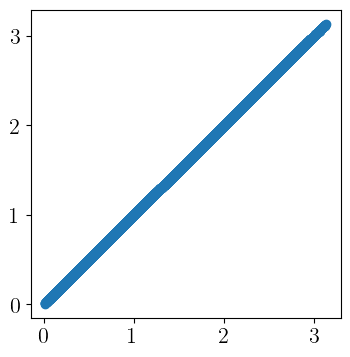

In [7]:
hdul=fits.open('public_evolution_mybin2_step1.fits')
mybin2=Table(hdul[1].data)
hdul.close()
print(len(mybin2))
# let's make sure that they are one and the same:
fig=plt.figure(figsize=(4,4))
plt.scatter(temp2['inc'], mybin2['inc'])
plt.show()
plt.close()

285640


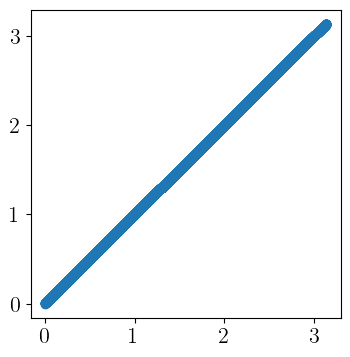

In [8]:
hdul=fits.open('public_evolution_mybin0.fits')
mybin0=Table(hdul[1].data)
hdul.close()
print(len(mybin0))
# let's make sure that they are one and the same:
fig=plt.figure(figsize=(4,4))
plt.scatter(temp0['inc'], mybin0['inc'])
plt.show()
plt.close()

In [9]:
# OK, it doesn't look like I re-wrote the inclinations when doing hamiltonian calculations in step 1: 
print(temp['inc'][0:5])
print(mybin2['inc'][0:5])

       inc        
------------------
 1.286351151913307
1.9693739791729734
2.1870353557535402
0.3186297621677949
1.1720182274802988
       inc        
------------------
 2.788217873875303
1.9678477780303747
1.6413646263624668
1.4839517282923267
1.8128957933645085


In [10]:
mybin2[0:5]

m1,m2,bday,sma,ecc_slope,ecc,death1,death2,class,omega,asclong,mean_anomaly,inc,omega_step2,asclong_step2,mean_step2,inc_step2,fm1,fm2,tintegrate,tfinal,eta_out,eta_in,fecc,fsma,vkick
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.9902561635852916,0.9817032607675428,0.4533785074962746,3.3345553396513554,0.0,0.927747636133542,1.4542891484521778,10.05039862110605,2.0,0.9357458037524299,0.0249949333856721,2.7952856964964377,2.788217873875303,3.223941855610792,2.5955795408994,5.870974307641684,2.047541777450186,0.6482204930868233,0.5675362608614034,107898.38399446558,677945.5409824471,0.00010906965125232452,3.28059599974079e-05,0.9293537735030855,6.080139113420385,0.28044693231750767
5.0825253896770395,1.6887638768356077,9.504068850724313,2609.6792736012167,1.2977768608735358,0.9452905191745385,9.587374461284313,11.154783264853535,2.0,0.6228425833337472,2.9774624581447195,2.7593735319847874,1.9678477780303747,0.33027556213240367,4.649047292847102,5.123560683963348,0.4913388048838077,1.0148302166954433,0.6241011101468485,2021.8015896505385,12703.354042124594,159.29365552171242,25.394444816181576,0.9437036715298489,2597.9203984661585,0.40277173442680175
8.872125599661503,1.163054764187087,0.331598163745106,1442.0090697724147,1.243210738459513,0.722716494129941,0.3582030342704275,5.781177069601807,2.0,5.519202884313555,2.4394888139179485,4.01730307282566,1.6413646263624668,2.27394250444646,4.487950964819781,1.9744797069823496,1.7351922062763383,1.5297023221416375,0.5820443811349669,1000.0,6283.185307179586,240.59003871501096,17.322941226002573,0.5824299280237608,1625.3488365261287,0.4394603127561486
7.502660930143531,1.5682398082256783,6.8857463364682445,2245.987350960255,1.2866295190598906,0.707981356903753,6.922232456157433,8.965298167471339,2.0,0.0369990762560518,3.244930217842437,5.253284535653998,1.4839517282923267,2.1568057147366426,3.931482377182844,2.9950203797065704,1.452256696033596,1.2935837887055806,0.6144591846580543,1000.0,6283.185307179586,355.822245051255,35.41750688714736,1.2929265869646713,-2784.9191385296103,0.43946031275614855
1.1977474551615077,1.1950604324674297,1.778476225196901,114.35926206571602,0.3834239217093989,0.9623448016485942,6.725340229384569,6.761986162902291,2.0,2.877493861157235,3.8314322121098754,4.5568251857273605,1.8128957933645085,2.887154411887237,6.2468569348643594,2.4713004646483947,2.2157084049097535,0.5848197964129206,0.5846048345973943,930236.2465571665,5844846.716573875,0.0015393103290356218,0.0008517106505684417,0.9413395823655272,153.74053818576635,0.17922354790513828


<h3>Let's remind ourselves what the relevant columns are:</h3>
<p> m1-fm1
<p> m2-fm2
<p> ecc_slope, bday, death1, death2 no longer relevant
<p> <b>Step 1:</b>
<br> sma, ecc, omega, asclong, mean_anomaly, inc are all inputs for the first step of the evolution
<br> eta_out, eta_in are calculation criteria for the first step of the evolution
<br> vkick is also for the first step of the evolution
<p> <b>Step 2: </b>
<br> fsma, fecc, omega_step2, asclong_step2, mean_step2, inc_step2 are all inputs for the second step of the evolution
<br> So need to start setting up the rest of the parameters again

In [11]:
# how many are disrupted? 
print('all WD-WD binaries:',len(mybin2),', disrupted after step 1:',len(mybin2[(mybin2['fsma']<0)]),len(mybin2[(mybin2['fecc']>1)]))

all WD-WD binaries: 35023 , disrupted after step 1: 6835 6835


In [12]:
def tint(mass):
    # this is the integration time, in years, in this model where it steeply depends on mass
    m1=1.0
    t1=2e6
    m2=6.0
    t2=1e3
    mass=np.array(mass)
    y=np.zeros(len(mass))
    k=np.log(t2/t1)/np.log(m2/m1)
    y=t1*(mass/m1)**k
    ind=(mass<=m1)
    y[ind]=t1
    ind=(mass>=m2)
    y[ind]=t2
    return(y)
mybin2['tintegrate']=tint(mybin2['m2'])
mybin2['tfinal']=mybin2['tintegrate']*tunit

In [13]:
# these are step 2, and we need to be super-careful replacing parameters with the results from step 1
mybin2['eta_out2']=eta_parameter(mybin2['tintegrate'],mybin2['fm1']+mybin2['fm2'],
                                abs(mybin2['fsma'])*(mybin2['fm1']+mybin2['m2'])/(mybin2['fm1']+mybin2['fm2']))
mybin2['eta_in2']=eta_parameter(mybin2['tintegrate'],mybin2['fm1']+mybin2['m2'],abs(mybin2['fsma']))
# these are the ones already disrupted
ind_dis=(mybin2['fsma']<=0)
ind_imp=((mybin2['eta_out2']>eta_impact) & (mybin2['eta_in2']>eta_impact) & (mybin2['fsma']>0))
ind_ham=((mybin2['eta_out2']<eta_ham) & (mybin2['eta_in2']<eta_ham) & (mybin2['fsma']>0))
ind_dir=((~ind_imp) & (~ind_ham) & (~ind_dis))
print('disrupted:', len(mybin2[ind_dis]))
print('impulsive: ', len(mybin2[ind_imp]))
print('Hamiltonian: ', len(mybin2[ind_ham]))
print('direct: ', len(mybin2[ind_dir]))
print('total: ', len(mybin2), 'sum of  categories: ', len(mybin2[ind_dis])+len(mybin2[ind_imp])+
      len(mybin2[ind_ham])+len(mybin2[ind_dir]))

disrupted: 6835
impulsive:  1003
Hamiltonian:  18521
direct:  8664
total:  35023 sum of  categories:  35023


In [14]:
# there were some NaN values from the Hamiltonian calculation:
check_nan=np.isnan(mybin2['fecc'])
print(np.where(check_nan==True))
# and let's just fix these values to the initial eccentricity values:
mynan=np.where(check_nan==True)[0]
print("Houston, you should really figure out why the Hamiltonian calculation breaks down in these cases, but for now we just fix them", len(mynan), mynan)
mybin2['fecc'][mynan]=np.copy(mybin2['ecc'][mynan])

(array([], dtype=int64),)
Houston, you should really figure out why the Hamiltonian calculation breaks down in these cases, but for now we just fix them 0 []


In [15]:
# create final states for SMAs and eccentricities assuming just adiabatic evolution with no kick.
mybin2['fecc2']=mybin2['fecc']
mybin2['fsma2']=mybin2['fsma']*(mybin2['fm1']+mybin2['m2'])/(mybin2['fm1']+mybin2['fm2'])
# this is in km/sec
mybin2['vkick2']=vasym*np.log(mybin2['m2']/mybin2['fm2'])

<h3>Impulsive, step 2:</h3>

In [16]:
# ind_imp: 
# let's now deal with the impulse approximation category, except that the orbit table needs to be defined carefully 
# based on the post-step 1 values
orbit = Table([mybin2[ind_imp]['fsma'], mybin2[ind_imp]['fecc'], mybin2[ind_imp]['inc_step2'], 
               mybin2[ind_imp]['asclong_step2'], mybin2[ind_imp]['omega_step2'], mybin2[ind_imp]['mean_step2']],
           names=('sma', 'ecc', 'inc', 'asclong', 'omega', 'mean_anomaly'))
# I am retaining the - sign here. It really shouldn't matter, and I just can't figure out what to do with it
u=np.transpose([np.zeros(len(orbit)),np.zeros(len(orbit)),-np.array(mybin2[ind_imp]['vkick2'])*vunit])
new_orbit=Table(orbital.one_kick_loss(mybin2[ind_imp]['fm1'],mybin2[ind_imp]['m2'],mybin2[ind_imp]['m2']-mybin2[ind_imp]['fm2'],u,orbit))

In [17]:
ind_retained=(new_orbit['sma']>0)
print(len(new_orbit[ind_retained]))
# Let's populate the relevant columns in the main table:
mybin2['fsma2'][ind_imp]=np.array(new_orbit['sma'])
mybin2['fecc2'][ind_imp]=np.array(new_orbit['ecc'])
# OK, done with the impulsive part! 

206


<h3>Hamiltonian, step 2:</h3>

In [18]:
# let's deal with the hamiltonian sources
ham = Table([mybin2[ind_ham]['fsma'], mybin2[ind_ham]['fecc'], mybin2[ind_ham]['inc_step2'], 
               mybin2[ind_ham]['asclong_step2'], mybin2[ind_ham]['omega_step2'], 
               mybin2[ind_ham]['mean_step2'], mybin2[ind_ham]['fm1'], mybin2[ind_ham]['m2'],
               mybin2[ind_ham]['fm2'], mybin2[ind_ham]['fecc2'], mybin2[ind_ham]['fsma2'], 
               mybin2[ind_ham]['tintegrate'], mybin2[ind_ham]['tfinal']],
               names=('sma', 'ecc', 'inc', 'asclong', 'omega', 'mean_anomaly', 'fm1', 'm2', 'fm2', 
               'fecc2', 'fsma2', 'tintegrate', 'tfinal'), copy=True)
print(len(ham))
ham[0:5]

18521


sma,ecc,inc,asclong,omega,mean_anomaly,fm1,m2,fm2,fecc2,fsma2,tintegrate,tfinal
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
6.080139113420385,0.9293537735030855,2.047541777450186,2.5955795408994,3.223941855610792,5.870974307641684,0.6482204930868233,0.9817032607675428,0.5675362608614034,0.9293537735030855,8.15143583247158,2000000.0,12566370.614359172
153.74053818576635,0.9413395823655272,2.2157084049097535,6.2468569348643594,2.887154411887237,2.4713004646483947,0.5848197964129206,1.1950604324674297,0.5846048345973943,0.9413395823655272,233.99519476330954,939141.4306845808,5900799.638640974
0.15381713864241933,0.6514799246411793,1.8326194081577045,1.4986330714447165,6.1720477213651845,4.710275055348745,0.5876132665476068,1.0807777526560802,0.5754622202124864,0.6514799246411793,0.22064529399161442,1438518.096604742,9038475.76869886
14.315737755134572,0.9480643981220761,1.5797341181379247,0.1638413509156397,2.7218515739619997,4.575278695300763,0.6858844444904628,1.8433197305804299,0.6364655784464344,0.9480643981220761,27.381119273617767,149387.2678198048,938627.8862450994
23.403444820617494,0.4153094173024435,1.6512229420476432,5.935533641405631,2.116464757667889,5.328748439946023,0.6578419745111712,1.974226346180713,0.646938107694457,0.4153094173024435,47.2106116176136,111664.0812050165,701606.1143670678


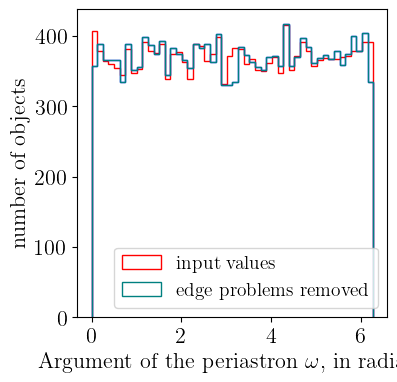

In [19]:
# first, let's avoid the pathological initial conditions omega=0, pi, 2pi and inc=0, pi/2, pi.
tol=1.*np.pi/180. 
new_omega=np.array(ham['omega'])
ind1=(new_omega<=np.pi)
new_omega[ind1]=tol+new_omega[ind1]*(np.pi-2*tol)/np.pi
ind2=(new_omega>np.pi)
new_omega[ind2]=(np.pi+tol)+(new_omega[ind2]-np.pi)*(np.pi-2*tol)/np.pi
fig=plt.figure(figsize=(4,4))
n_bins=50
(n, bins, patches)=plt.hist(np.array(ham['omega']), n_bins, histtype='step', stacked=True, fill=False, color='red', label='input values')
plt.hist(new_omega, bins, histtype='step', stacked=True, fill=False, color='blue')
ham['omega']=np.copy(new_omega)
plt.hist(np.array(ham['omega']), bins, histtype='step', stacked=True, fill=False, color='teal', label='edge problems removed')
plt.xlabel(r'Argument of the periastron $\omega$, in radians')
plt.ylabel(r'number of objects')
plt.legend(loc='lower right')
plt.show()
plt.close()

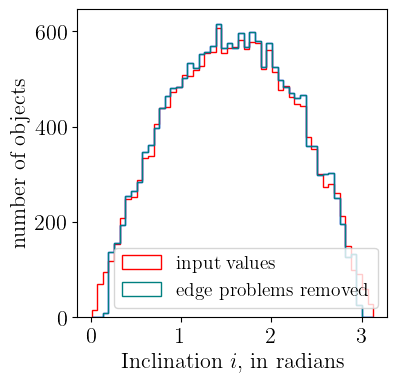

In [20]:
xx=np.cos(ham['inc'])
ind1=(xx>=0.)
xx[ind1]=tol**2+xx[ind1]*(1.-tol-tol**2)
ind2=(xx<0.)
xx[ind2]=-tol**2+xx[ind2]*(1.-tol-tol**2)
fig=plt.figure(figsize=(4,4))
(n, bins, patches)=plt.hist(np.array(ham['inc']), n_bins, histtype='step', stacked=True, fill=False, color='red', label='input values')
plt.hist(np.arccos(xx), bins, histtype='step', stacked=True, fill=False, color='blue')
ham['inc']=np.copy(np.arccos(xx))
plt.hist(np.array(ham['inc']), bins, histtype='step', stacked=True, fill=False, color='teal', label='edge problems removed')
plt.xlabel(r'Inclination $i$, in radians')
plt.ylabel(r'number of objects')
plt.legend(loc='lower right')
plt.show()
plt.close()

In [21]:
myfile=open('hamiltonian_errors_step2.txt','w')
myfile.write('')
myfile.close()
myfile=open('hamiltonian_errors_step2.txt','a')

t0 = time.time()
for i, obj in enumerate(ham):
    Lin=np.sqrt((obj['fm1']+obj['m2'])*obj['sma'])
    Jin=Lin*np.sqrt(1-obj['ecc']**2)
    Jzin=Jin*np.cos(obj['inc'])
    # the min number of steps in the Hamiltonian integration: 
    minnum=10000
    deltam=obj['m2']-obj['fm2']
    tfinal=obj['tfinal']
    
    def tm(t, tfinal=tfinal):
    # linearly declining to the final value, time is in code units
        return(obj['fm1']+obj['m2']-deltam*t/tfinal)
    def ak(t, tfinal=tfinal):
    # the time is in the code units and the acceleration is in the code units
        return(vasym*vunit*deltam/(obj['m2']*tfinal-deltam*t))
    deltat_code=np.sqrt(tm(tfinal)/obj['sma'])/ak(tfinal)/minnum
    nsteps=max(minnum, int(tfinal/deltat_code))
    t_eval=np.linspace(0, tfinal, nsteps)
    def rhs(t, v): 
        tol=1.e-14
        par1=max(tol,1-v[0]**2/Lin**2)
        par2=max(tol,1-Jzin**2/v[0]**2)
        return [-ak(t)*np.cos(v[1])*1.5*np.sqrt(par1)*Lin**2/tm(t)*np.sqrt(par2),
           ak(t)*1.5*Lin**2*np.sin(v[1])*(Jzin**2/v[0]**3-v[0]/Lin**2)/(tm(t)*np.sqrt(par1)*np.sqrt(par2))]
    res = solve_ivp(rhs, (0, tfinal), [Jin, obj['omega']], t_eval=t_eval)
    if (1-res.y[0][nsteps-1]**2/Lin**2<0): 
        myfile.write(str(i))
        myfile.write(str(obj))
        myfile.write('\n')
    ham['fecc2'][i]=np.sqrt(1-res.y[0][nsteps-1]**2/Lin**2)
t1 = time.time()
print('execution time, sec ', t1-t0)
myfile.close() # there are no errors in step2 file, and it no longer throws off the error message

execution time, sec  17.04086184501648


In [22]:
mybin2['fecc2'][ind_ham]=np.copy(ham['fecc2'])
# the sma is just the adiabatic expansion, so it's already done! 

<h3>Direct integration for step 2:</h3>

In [23]:
direct=Table(mybin2[ind_dir], copy=True)

In [24]:
rvec0,vvec0=orbital.cart_from_orbital(direct['fm1']+direct['m2'], direct['fsma'], direct['fecc'], direct['inc_step2'], 
                              direct['asclong_step2'], direct['omega_step2'], direct['mean_step2'])

In [25]:
t0 = time.time()
counter=0
for i, myrow in enumerate(direct):
    counter=counter+1
    if (counter==1000):
        counter=0
        print('evaluating i=', i, 'out of ', len(direct))
    rvec=rvec0[i]
    vvec=vvec0[i]
    obj=Table(myrow, copy=True)
    deltam=obj['m2']-obj['fm2']
    tfinal=obj['tfinal'][0]
    
    def tm(t, tf=tfinal):
    # total mass is linearly declining to the final value, time is in code units
        return(obj['fm1'][0]+obj['m2'][0]-deltam[0]*t/tf)
        #return(obj['m1'][0]+obj['m2'][0])
    def ak(t, tf=tfinal):
    # the time is in the code units and the acceleration is in the code units
        return(vasym*vunit*deltam[0]/(obj['m2'][0]*tf-deltam[0]*t))
        #return(ak_code)

    minnum=100
    deltat_code=orbital.per(obj['fm1'][0]+obj['m2'][0],obj['fsma'][0])*tunit/minnum
    # this is the total number of steps: 
    nsteps=max(minnum, int(tfinal/deltat_code))
    t_eval=np.linspace(0, tfinal, nsteps)
    qqx=rvec[0]
    qqy=rvec[1]
    qqz=rvec[2]
    ppx=vvec[0]
    ppy=vvec[1]
    ppz=vvec[2]
    hh=t_eval[1]-t_eval[0]
    for j in np.arange(1,nsteps):
        q12x=qqx+0.5*hh*ppx
        q12y=qqy+0.5*hh*ppy
        q12z=qqz+0.5*hh*ppz
        r=np.sqrt(q12x**2+q12y**2+q12z**2)
        t12=hh*j+0.5*hh
        ppx=ppx-hh*tm(t12)*q12x/r**3
        ppy=ppy-hh*tm(t12)*q12y/r**3
        ppz=ppz-hh*tm(t12)*q12z/r**3+hh*ak(t12)
        qqx=q12x+0.5*hh*ppx
        qqy=q12y+0.5*hh*ppy
        qqz=q12z+0.5*hh*ppz
    qq=np.array([qqx,qqy,qqz])
    pp=np.array([ppx,ppy,ppz])
    (leap_sma,leap_ecc,leap_inc,leap_asclong,leap_omega,leap_true)=orbital.orbital_from_cart(tm(tfinal),qq,pp)

    direct['fecc2'][i]=leap_ecc[0]
    direct['fsma2'][i]=leap_sma[0]
#    direct['finc2'][i]=leap_inc[0]
t1 = time.time()
print('execution time, sec ', t1-t0)

evaluating i= 999 out of  8664
evaluating i= 1999 out of  8664
evaluating i= 2999 out of  8664
evaluating i= 3999 out of  8664
evaluating i= 4999 out of  8664
evaluating i= 5999 out of  8664
evaluating i= 6999 out of  8664
evaluating i= 7999 out of  8664
execution time, sec  88.94476199150085


In [26]:
#mybin2['finc2'][ind_dir]=np.copy(direct['finc2'])
mybin2['fecc2'][ind_dir]=np.copy(direct['fecc2'])
mybin2['fsma2'][ind_dir]=np.copy(direct['fsma2'])

In [27]:
mybin2.write('public_evolution_mybin2.fits', format='fits', overwrite=True)


In [28]:
# how many are retained vs disrupted?
temp=(direct['fsma2']<0)
print(len(direct), len(direct[temp]))

8664 1495


In [29]:
# let's check the total number of disrupted objects:
temp=(mybin2['fsma2']<0)
print(len(mybin2), len(mybin2[temp]))
print('disrupted at step 1', 7080, 'disrupted at impulsive: ', 50, 'disrupted at direct: ', 2561)
print('sum should be the same: ', 7080+50+2561)

35023 9127
disrupted at step 1 7080 disrupted at impulsive:  50 disrupted at direct:  2561
sum should be the same:  9691


<h1>Some plots</h1>

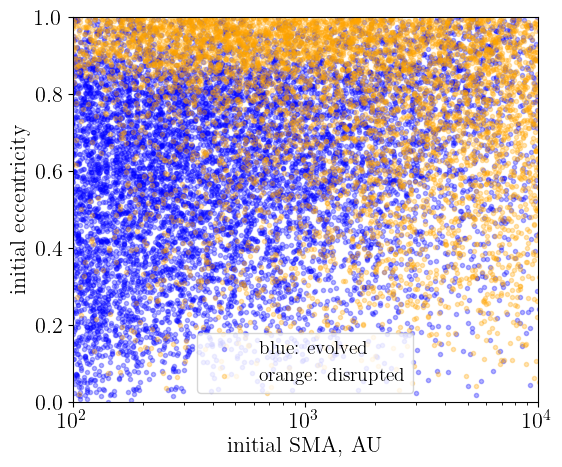

In [30]:
fig=plt.figure()
ind=(mybin2['fsma2']<0) #these are disrupted
plt.scatter(mybin2['sma'][~ind],mybin2['ecc'][~ind],color='blue',marker='.',alpha=0.3,label='blue: evolved')
plt.scatter(mybin2['sma'][ind],mybin2['ecc'][ind],color='orange',marker='.', alpha=0.3,label='orange: disrupted')
plt.xlabel('initial SMA, AU')
plt.ylabel('initial eccentricity')
plt.xlim((1e2,1e4))
plt.ylim((0.,1.))
plt.xscale('log')
plt.legend(loc='lower center')
plt.show()
plt.close()

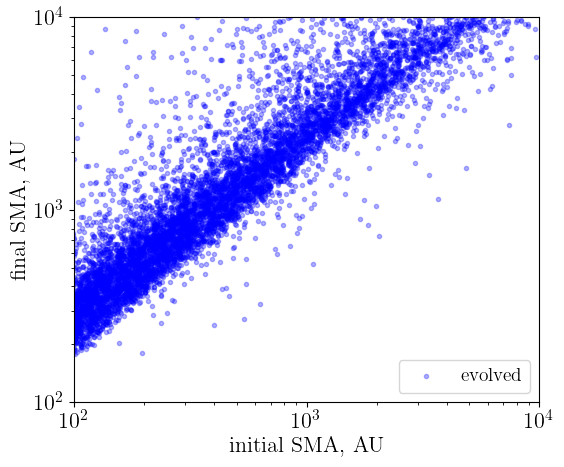

In [31]:
fig=plt.figure()
plt.scatter(mybin2['sma'][~ind],mybin2['fsma2'][~ind],color='blue',marker='.',alpha=0.3,label='evolved')
plt.xlabel('initial SMA, AU')
plt.ylabel('final SMA, AU')
plt.xlim((1e2,1e4))
plt.ylim((1e2,1e4))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')
plt.show()
plt.close()

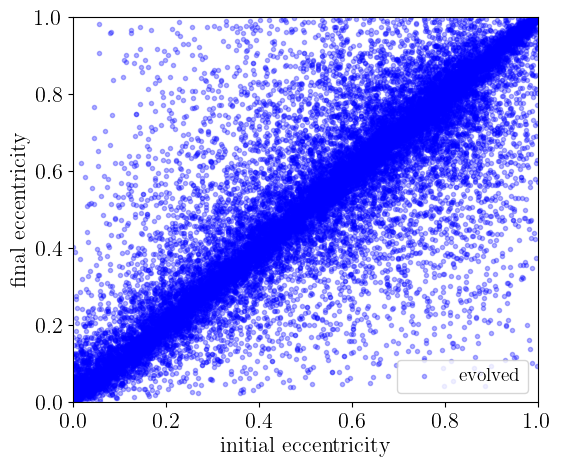

In [32]:
fig=plt.figure()
plt.scatter(mybin2['ecc'][~ind],mybin2['fecc2'][~ind],color='blue',marker='.',alpha=0.3,label='evolved')
plt.xlabel('initial eccentricity')
plt.ylabel('final eccentricity')
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(loc='lower right')
plt.show()
plt.close()

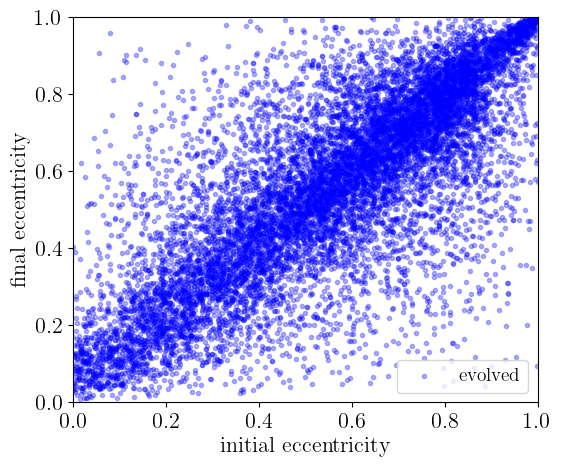

In [33]:
#same but for wide binaries
ind=((mybin2['fsma2']>100) & (mybin2['fsma2']<1e4))
fig=plt.figure()
plt.scatter(mybin2['ecc'][ind],mybin2['fecc2'][ind],color='blue',marker='.',alpha=0.3,label='evolved')
plt.xlabel('initial eccentricity')
plt.ylabel('final eccentricity')
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(loc='lower right')
plt.show()
plt.close()

2.25 number of MS-WD binaries in the bin  34035 at birth  36325
2.25 number of WD-WD binaries in the bin  4015 at birth  4479
2.75 number of MS-WD binaries in the bin  28266 at birth  32595
2.75 number of WD-WD binaries in the bin  3597 at birth  4036
3.25 number of MS-WD binaries in the bin  20204 at birth  26154
3.25 number of WD-WD binaries in the bin  2522 at birth  3298
3.75 number of MS-WD binaries in the bin  13817 at birth  19101
3.75 number of WD-WD binaries in the bin  1691 at birth  2462
4.25 number of MS-WD binaries in the bin  7238 at birth  12257
4.25 number of WD-WD binaries in the bin  806 at birth  1594
4.75 number of MS-WD binaries in the bin  2787 at birth  7207
4.75 number of WD-WD binaries in the bin  262 at birth  951


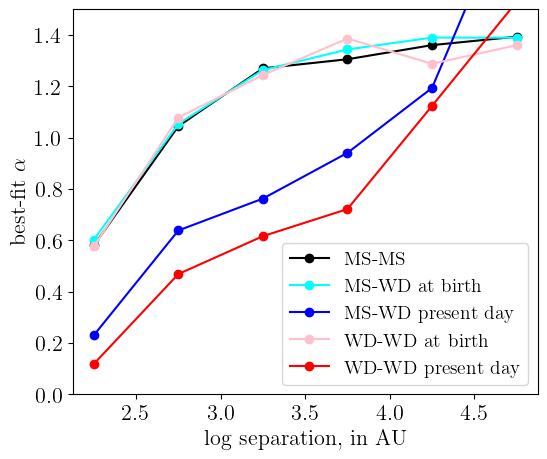

In [34]:
# let's do the eccentricity distribution! 
lg_fsma_bins=np.arange(2.25,5.25,0.5)
# set up empty arrays
alpha_msms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdms=np.zeros(len(lg_fsma_bins))
alpha_wdms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdwd=np.zeros(len(lg_fsma_bins))
alpha_wdwd=np.zeros(len(lg_fsma_bins))
for i,lg_fsma in enumerate(lg_fsma_bins):
    ind1=((mybin1['sma']>=10**(lg_fsma-0.25)) & (mybin1['sma']<10**(lg_fsma+0.25)))
    birth0=((mybin0['sma']>=10**(lg_fsma-0.25)) & (mybin0['sma']<10**(lg_fsma+0.25)))
    ind0=((mybin0['fsma']>=10**(lg_fsma-0.25)) & (mybin0['fsma']<10**(lg_fsma+0.25)) & (mybin0['fecc']<1))
    birth2=((mybin2['sma']>=10**(lg_fsma-0.25)) & (mybin2['sma']<10**(lg_fsma+0.25)))
    ind2=((mybin2['fsma2']>=10**(lg_fsma-0.25)) & (mybin2['fsma2']<10**(lg_fsma+0.25)) & (mybin2['fecc2']<1))
    alpha_msms[i]=orbital.max_likelihood_ecc(mybin1['ecc'][ind1])
    alpha_birth_wdms[i]=orbital.max_likelihood_ecc(mybin0['ecc'][birth0])
    alpha_wdms[i]=orbital.max_likelihood_ecc(mybin0['fecc'][ind0])
    alpha_birth_wdwd[i]=orbital.max_likelihood_ecc(mybin2['ecc'][birth2])
    alpha_wdwd[i]=orbital.max_likelihood_ecc(mybin2['fecc2'][ind2])
    print(lg_fsma, 'number of MS-WD binaries in the bin ', len(mybin0[ind0]), 'at birth ',  len(mybin0[birth0]))
    print(lg_fsma, 'number of WD-WD binaries in the bin ', len(mybin2[ind2]), 'at birth ',  len(mybin2[birth2]))
fig=plt.figure()
fig.patch.set_facecolor('white')
plt.plot(lg_fsma_bins,alpha_msms,color='black', marker='o', label='MS-MS')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdms,color='cyan', marker='o', label='MS-WD at birth')                                  
plt.plot(lg_fsma_bins,alpha_wdms,color='blue', marker='o', label='MS-WD present day')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdwd,color='pink', marker='o', label='WD-WD at birth')                                  
plt.plot(lg_fsma_bins,alpha_wdwd,color='red', marker='o', label='WD-WD present day')                                  
plt.legend(loc='lower right')
plt.ylim((0.,1.5))
plt.xlabel('log separation, in AU')
plt.ylabel(r'best-fit $\alpha$')
#plt.savefig('public_evolution_ecc_distribution.png')
plt.show()
plt.close()

2.25 number of MS-WD binaries in the bin  34035 at birth  36325
2.25 number of WD-WD binaries in the bin  4015 at birth  4479
2.75 number of MS-WD binaries in the bin  28266 at birth  32595
2.75 number of WD-WD binaries in the bin  3597 at birth  4036
3.25 number of MS-WD binaries in the bin  20204 at birth  26154
3.25 number of WD-WD binaries in the bin  2522 at birth  3298
3.75 number of MS-WD binaries in the bin  13817 at birth  19101
3.75 number of WD-WD binaries in the bin  1691 at birth  2462
4.25 number of MS-WD binaries in the bin  7238 at birth  12257
4.25 number of WD-WD binaries in the bin  806 at birth  1594
4.75 number of MS-WD binaries in the bin  2787 at birth  7207
4.75 number of WD-WD binaries in the bin  262 at birth  951


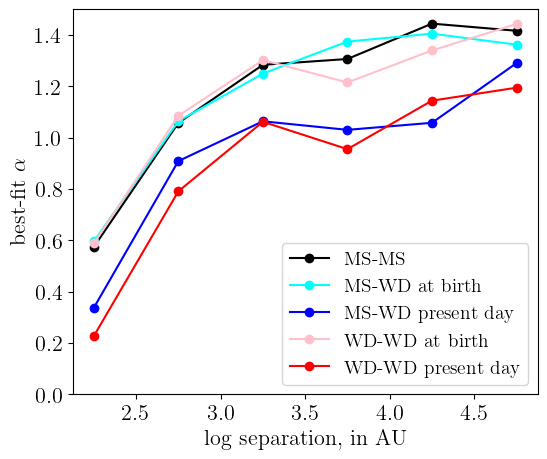

In [35]:
# let's do the eccentricity distribution! 
lg_fsma_bins=np.arange(2.25,5.25,0.5)
# set up empty arrays
alpha_msms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdms=np.zeros(len(lg_fsma_bins))
alpha_wdms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdwd=np.zeros(len(lg_fsma_bins))
alpha_wdwd=np.zeros(len(lg_fsma_bins))
for i,lg_fsma in enumerate(lg_fsma_bins):
    ind1=((mybin1['sma']>=10**(lg_fsma-0.25)) & (mybin1['sma']<10**(lg_fsma+0.25)))
    birth0=((mybin0['sma']>=10**(lg_fsma-0.25)) & (mybin0['sma']<10**(lg_fsma+0.25)))
    ind0=((mybin0['fsma']>=10**(lg_fsma-0.25)) & (mybin0['fsma']<10**(lg_fsma+0.25)) & (mybin0['fecc']<1))
    birth2=((mybin2['sma']>=10**(lg_fsma-0.25)) & (mybin2['sma']<10**(lg_fsma+0.25)))
    ind2=((mybin2['fsma2']>=10**(lg_fsma-0.25)) & (mybin2['fsma2']<10**(lg_fsma+0.25)) & (mybin2['fecc2']<1))
    alpha_msms[i]=orbital.max_likelihood_ecc(mybin1['ecc'][ind1], emax=0.7)
    alpha_birth_wdms[i]=orbital.max_likelihood_ecc(mybin0['ecc'][birth0], emax=0.7)
    alpha_wdms[i]=orbital.max_likelihood_ecc(mybin0['fecc'][ind0], emax=0.7)
    alpha_birth_wdwd[i]=orbital.max_likelihood_ecc(mybin2['ecc'][birth2], emax=0.7)
    alpha_wdwd[i]=orbital.max_likelihood_ecc(mybin2['fecc2'][ind2], emax=0.7)
    print(lg_fsma, 'number of MS-WD binaries in the bin ', len(mybin0[ind0]), 'at birth ',  len(mybin0[birth0]))
    print(lg_fsma, 'number of WD-WD binaries in the bin ', len(mybin2[ind2]), 'at birth ',  len(mybin2[birth2]))
fig=plt.figure()
fig.patch.set_facecolor('white')
plt.plot(lg_fsma_bins,alpha_msms,color='black', marker='o', label='MS-MS')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdms,color='cyan', marker='o', label='MS-WD at birth')                                  
plt.plot(lg_fsma_bins,alpha_wdms,color='blue', marker='o', label='MS-WD present day')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdwd,color='pink', marker='o', label='WD-WD at birth')                                  
plt.plot(lg_fsma_bins,alpha_wdwd,color='red', marker='o', label='WD-WD present day')                                  
plt.legend(loc='lower right')
plt.ylim((0.,1.5))
plt.xlabel('log separation, in AU')
plt.ylabel(r'best-fit $\alpha$')
#plt.savefig('public_evolution_ecc_distribution.png')
plt.show()
plt.close()

2.25 number of WD-MS binaries in the bin  34035 at birth  36325
2.25 number of WD-WD binaries in the bin  4015 at birth  4479
2.75 number of WD-MS binaries in the bin  28266 at birth  32595
2.75 number of WD-WD binaries in the bin  3597 at birth  4036
3.25 number of WD-MS binaries in the bin  20204 at birth  26154
3.25 number of WD-WD binaries in the bin  2522 at birth  3298
3.75 number of WD-MS binaries in the bin  13817 at birth  19101
3.75 number of WD-WD binaries in the bin  1691 at birth  2462
4.25 number of WD-MS binaries in the bin  7238 at birth  12257
4.25 number of WD-WD binaries in the bin  806 at birth  1594
4.75 number of WD-MS binaries in the bin  2787 at birth  7207
4.75 number of WD-WD binaries in the bin  262 at birth  951


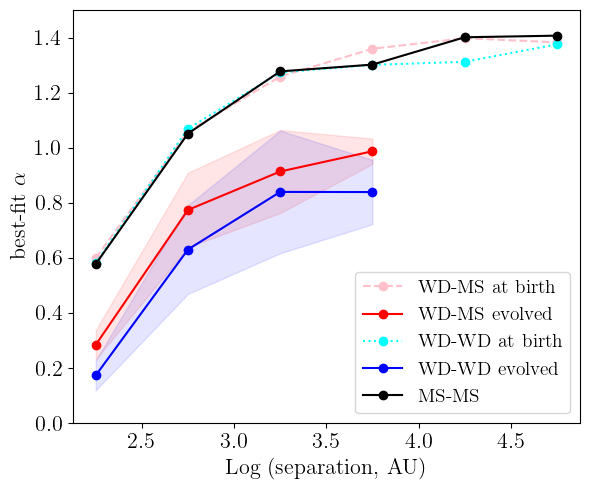

In [36]:
# let's do the eccentricity distribution with some err bars
lg_fsma_bins=np.arange(2.25,5.25,0.5)
# set up empty arrays
alpha_msms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdms=np.zeros(len(lg_fsma_bins))
alpha_wdms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdwd=np.zeros(len(lg_fsma_bins))
alpha_wdwd=np.zeros(len(lg_fsma_bins))
err_alpha_msms=np.zeros(len(lg_fsma_bins))
err_alpha_birth_wdms=np.zeros(len(lg_fsma_bins))
err_alpha_wdms=np.zeros(len(lg_fsma_bins))
err_alpha_birth_wdwd=np.zeros(len(lg_fsma_bins))
err_alpha_wdwd=np.zeros(len(lg_fsma_bins))
temp=np.zeros(4)
for i,lg_fsma in enumerate(lg_fsma_bins):
    ind1=((mybin1['sma']>=10**(lg_fsma-0.25)) & (mybin1['sma']<10**(lg_fsma+0.25)))
    birth0=((mybin0['sma']>=10**(lg_fsma-0.25)) & (mybin0['sma']<10**(lg_fsma+0.25)))
    ind0=((mybin0['fsma']>=10**(lg_fsma-0.25)) & (mybin0['fsma']<10**(lg_fsma+0.25)) & (mybin0['fecc']<1))
    birth2=((mybin2['sma']>=10**(lg_fsma-0.25)) & (mybin2['sma']<10**(lg_fsma+0.25)))
    ind2=((mybin2['fsma2']>=10**(lg_fsma-0.25)) & (mybin2['fsma2']<10**(lg_fsma+0.25)) & (mybin2['fecc2']<1))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin1['ecc'][ind1], emax=emax)
    alpha_msms[i]=0.5*(max(temp)+min(temp))
    err_alpha_msms[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin0['ecc'][birth0], emax=emax)
    alpha_birth_wdms[i]=0.5*(max(temp)+min(temp))
    err_alpha_birth_wdms[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin0['fecc'][ind0], emax=emax)
    alpha_wdms[i]=0.5*(max(temp)+min(temp))
    err_alpha_wdms[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin2['ecc'][birth2], emax=emax)
    alpha_birth_wdwd[i]=0.5*(max(temp)+min(temp))
    err_alpha_birth_wdwd[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin2['fecc2'][ind2], emax=emax)
    alpha_wdwd[i]=0.5*(max(temp)+min(temp))
    err_alpha_wdwd[i]=0.5*(max(temp)-min(temp))
    print(lg_fsma, 'number of WD-MS binaries in the bin ', len(mybin0[ind0]), 'at birth ',  len(mybin0[birth0]))
    print(lg_fsma, 'number of WD-WD binaries in the bin ', len(mybin2[ind2]), 'at birth ',  len(mybin2[birth2]))
fig=plt.figure()
fig.patch.set_facecolor('white')
u=(lg_fsma_bins<4)
plt.fill_between(lg_fsma_bins[u],alpha_wdms[u]-err_alpha_wdms[u],alpha_wdms[u]+err_alpha_wdms[u], color='red', alpha=0.1)
plt.fill_between(lg_fsma_bins[u],alpha_wdwd[u]-err_alpha_wdwd[u],alpha_wdwd[u]+err_alpha_wdwd[u], color='blue', alpha=0.1)
plt.plot(lg_fsma_bins,alpha_birth_wdms,color='pink', marker='o', linestyle='dashed', label='WD-MS at birth')                                  
plt.plot(lg_fsma_bins[u],alpha_wdms[u],color='red', marker='o', label='WD-MS evolved')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdwd,color='cyan', marker='o', linestyle='dotted', label='WD-WD at birth')                                  
plt.plot(lg_fsma_bins[u],alpha_wdwd[u],color='blue', marker='o', label='WD-WD evolved')                                  
plt.plot(lg_fsma_bins,alpha_msms,color='black', marker='o', label='MS-MS')                                  
plt.legend(loc='lower right')
plt.ylim((0.,1.5))
plt.xlabel('Log (separation, AU)')
plt.ylabel(r'best-fit $\alpha$')
fig.tight_layout()
plt.savefig('public_evolution_ecc_distribution.png')
plt.show()
plt.close()

2.25 number of WD-MS binaries in the bin  19959 at birth  36325
2.25 number of WD-WD binaries in the bin  4015 at birth  4479
2.75 number of WD-MS binaries in the bin  16640 at birth  32595
2.75 number of WD-WD binaries in the bin  3597 at birth  4036
3.25 number of WD-MS binaries in the bin  11903 at birth  26154
3.25 number of WD-WD binaries in the bin  2522 at birth  3298
3.75 number of WD-MS binaries in the bin  8107 at birth  19101
3.75 number of WD-WD binaries in the bin  1691 at birth  2462
4.25 number of WD-MS binaries in the bin  4374 at birth  12257
4.25 number of WD-WD binaries in the bin  806 at birth  1594
4.75 number of WD-MS binaries in the bin  1768 at birth  7207
4.75 number of WD-WD binaries in the bin  262 at birth  951


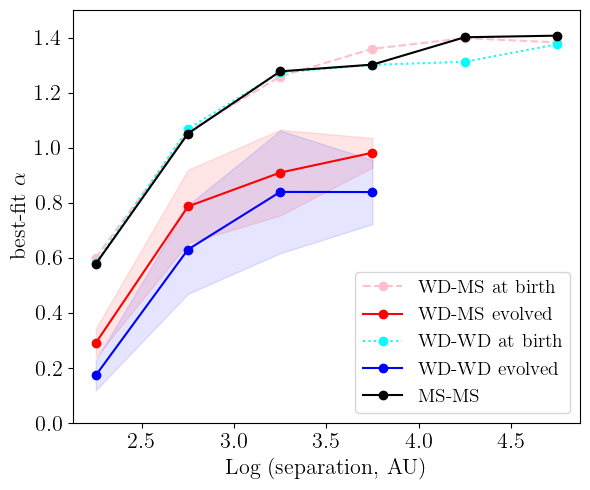

In [37]:
# let's do the eccentricity distribution with some err bars and apply the observational cuts on the MS companions
# of the WD-MS binaries
m_red=1.066 # this is the mass that corresponds to BP-RP>0.8 cut
m_bright=0.4326 # G<10.5 corresponds to BP-RP<2.667
# class=0 is the MS-WD binaries, those are the only ones affected

lg_fsma_bins=np.arange(2.25,5.25,0.5)
# set up empty arrays
alpha_msms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdms=np.zeros(len(lg_fsma_bins))
alpha_wdms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdwd=np.zeros(len(lg_fsma_bins))
alpha_wdwd=np.zeros(len(lg_fsma_bins))
err_alpha_msms=np.zeros(len(lg_fsma_bins))
err_alpha_birth_wdms=np.zeros(len(lg_fsma_bins))
err_alpha_wdms=np.zeros(len(lg_fsma_bins))
err_alpha_birth_wdwd=np.zeros(len(lg_fsma_bins))
err_alpha_wdwd=np.zeros(len(lg_fsma_bins))
temp=np.zeros(4)
for i,lg_fsma in enumerate(lg_fsma_bins):
    ind1=((mybin1['sma']>=10**(lg_fsma-0.25)) & (mybin1['sma']<10**(lg_fsma+0.25)))
    birth0=((mybin0['sma']>=10**(lg_fsma-0.25)) & (mybin0['sma']<10**(lg_fsma+0.25)))
    ind0=((mybin0['fsma']>=10**(lg_fsma-0.25)) & (mybin0['fsma']<10**(lg_fsma+0.25)) & (mybin0['fecc']<1) & (mybin0['m2']<m_red) & (mybin0['m2']>m_bright))
    birth2=((mybin2['sma']>=10**(lg_fsma-0.25)) & (mybin2['sma']<10**(lg_fsma+0.25)))
    ind2=((mybin2['fsma2']>=10**(lg_fsma-0.25)) & (mybin2['fsma2']<10**(lg_fsma+0.25)) & (mybin2['fecc2']<1))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin1['ecc'][ind1], emax=emax)
    alpha_msms[i]=0.5*(max(temp)+min(temp))
    err_alpha_msms[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin0['ecc'][birth0], emax=emax)
    alpha_birth_wdms[i]=0.5*(max(temp)+min(temp))
    err_alpha_birth_wdms[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin0['fecc'][ind0], emax=emax)
    alpha_wdms[i]=0.5*(max(temp)+min(temp))
    err_alpha_wdms[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin2['ecc'][birth2], emax=emax)
    alpha_birth_wdwd[i]=0.5*(max(temp)+min(temp))
    err_alpha_birth_wdwd[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin2['fecc2'][ind2], emax=emax)
    alpha_wdwd[i]=0.5*(max(temp)+min(temp))
    err_alpha_wdwd[i]=0.5*(max(temp)-min(temp))
    print(lg_fsma, 'number of WD-MS binaries in the bin ', len(mybin0[ind0]), 'at birth ',  len(mybin0[birth0]))
    print(lg_fsma, 'number of WD-WD binaries in the bin ', len(mybin2[ind2]), 'at birth ',  len(mybin2[birth2]))
fig=plt.figure()
fig.patch.set_facecolor('white')
u=(lg_fsma_bins<4)
plt.fill_between(lg_fsma_bins[u],alpha_wdms[u]-err_alpha_wdms[u],alpha_wdms[u]+err_alpha_wdms[u], color='red', alpha=0.1)
plt.fill_between(lg_fsma_bins[u],alpha_wdwd[u]-err_alpha_wdwd[u],alpha_wdwd[u]+err_alpha_wdwd[u], color='blue', alpha=0.1)
plt.plot(lg_fsma_bins,alpha_birth_wdms,color='pink', marker='o', linestyle='dashed', label='WD-MS at birth')                                  
plt.plot(lg_fsma_bins[u],alpha_wdms[u],color='red', marker='o', label='WD-MS evolved')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdwd,color='cyan', marker='o', linestyle='dotted', label='WD-WD at birth')                                  
plt.plot(lg_fsma_bins[u],alpha_wdwd[u],color='blue', marker='o', label='WD-WD evolved')                                  
plt.plot(lg_fsma_bins,alpha_msms,color='black', marker='o', label='MS-MS')                                  
plt.legend(loc='lower right')
plt.ylim((0.,1.5))
plt.xlabel('Log (separation, AU)')
plt.ylabel(r'best-fit $\alpha$')
fig.tight_layout()
#plt.savefig('public_evolution_ecc_distribution.png')
plt.show()
plt.close() # Yay, no difference, as expected

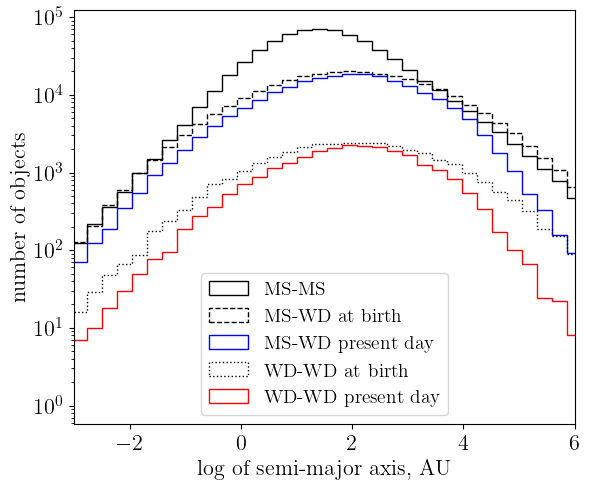

In [38]:
# let's compare initial and final SMAs
n_bins=50
fig=plt.figure()
fig.patch.set_facecolor('white')
(n,bins,patches)=plt.hist(np.log10(mybin1['sma']), n_bins, histtype='step', stacked=True, fill=False, color='black', label='MS-MS')
plt.hist(np.log10(mybin0['sma']), bins, histtype='step', stacked=True, fill=False, color='black', linestyle='dashed', label='MS-WD at birth')
ind0=(mybin0['fsma']>0)
plt.hist(np.log10(mybin0['fsma'][ind0]), bins, histtype='step', stacked=True, fill=False, color='blue', label='MS-WD present day')
plt.hist(np.log10(mybin2['sma']), bins, histtype='step', stacked=True, fill=False, color='black', linestyle='dotted', label='WD-WD at birth')
ind2=(mybin2['fsma2']>0)
plt.hist(np.log10(mybin2['fsma2'][ind2]), bins, histtype='step', stacked=True, fill=False, color='red', label='WD-WD present day')
plt.legend(loc='lower center')
plt.yscale('log')
plt.xlabel('log of semi-major axis, AU')
plt.ylabel('number of objects')
plt.xlim((-3.,6.))
fig.tight_layout()
#plt.savefig('public_evolution_sma_distribution.png')
plt.show()
plt.close()

cutoff WD mass= 0.64085779450193


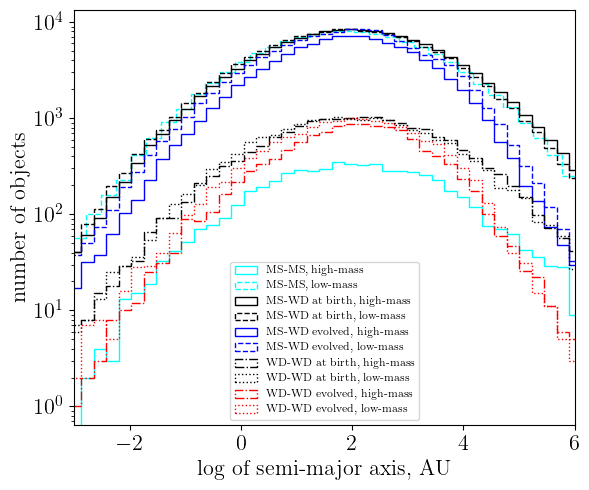

In [39]:
# same as above, but in two bins of WD mass: 
n_bins=50
# this is the median mass of a WD in an MS-WD pair: 
med_mass=np.median(mybin0['fm1'])
print("cutoff WD mass=",med_mass)
fig=plt.figure()
fig.patch.set_facecolor('white')
ind1a=(mybin1['fm1']>med_mass)
ind1b=((mybin1['fm1']<=med_mass) & (mybin1['m1']>0.92))
(n,bins,patches)=plt.hist(np.log10(mybin1['sma'][ind1a]), n_bins, histtype='step', stacked=True, fill=False, linestyle='solid', color='cyan', label='MS-MS, high-mass')
plt.hist(np.log10(mybin1['sma'][ind1b]), n_bins, histtype='step', stacked=True, fill=False, linestyle='dashed', color='cyan', label='MS-MS, low-mass')
# WD-MS
ind0a=(mybin0['fm1']>med_mass)
ind0b=(mybin0['fm1']<=med_mass)
plt.hist(np.log10(mybin0['sma'][ind0a]), bins, histtype='step', stacked=True, fill=False, color='black', linestyle='solid', label='MS-WD at birth, high-mass')
plt.hist(np.log10(mybin0['sma'][ind0b]), bins, histtype='step', stacked=True, fill=False, color='black', linestyle='dashed', label='MS-WD at birth, low-mass')
ind0c=(ind0a & (mybin0['fsma']>0))
ind0d=(ind0b & (mybin0['fsma']>0))
plt.hist(np.log10(mybin0['fsma'][ind0c]), bins, histtype='step', stacked=True, fill=False, color='blue', linestyle='solid', label='MS-WD evolved, high-mass')
plt.hist(np.log10(mybin0['fsma'][ind0d]), bins, histtype='step', stacked=True, fill=False, color='blue', linestyle='dashed', label='MS-WD evolved, low-mass')
# WD-WD
med_mass_pair=np.median(np.sqrt(mybin2['fm1']*mybin2['fm2']))
#ind2a=((mybin2['fm1']>med_mass) | (mybin2['fm2']>med_mass))
ind2a=(np.sqrt(mybin2['fm1']*mybin2['fm2'])>med_mass_pair)
ind2b=np.logical_not(ind2a)
plt.hist(np.log10(mybin2['sma'][ind2a]), bins, histtype='step', stacked=True, fill=False, color='black', linestyle='dashdot', label='WD-WD at birth, high-mass')
plt.hist(np.log10(mybin2['sma'][ind2b]), bins, histtype='step', stacked=True, fill=False, color='black', linestyle='dotted', label='WD-WD at birth, low-mass')
ind2c=((mybin2['fsma2']>0) & ind2a)
ind2d=((mybin2['fsma2']>0) & ind2b)
plt.hist(np.log10(mybin2['fsma2'][ind2c]), bins, histtype='step', stacked=True, fill=False, color='red', linestyle='dashdot', label='WD-WD evolved, high-mass')
plt.hist(np.log10(mybin2['fsma2'][ind2d]), bins, histtype='step', stacked=True, fill=False, color='red', linestyle='dotted', label='WD-WD evolved, low-mass')
plt.legend(prop = { "size": 8 }, loc='lower center')
plt.yscale('log')
plt.xlabel('log of semi-major axis, AU')
plt.ylabel('number of objects')
plt.xlim((-3.,6.))
fig.tight_layout()
#plt.savefig('public_evolution_sma_distribution.png')
plt.show()


In [40]:
# something doesn't compute here. I am seeing a factor of 2 difference between 
# high-mass and low-mass objects in terms of retention fraction that I am not seeing in the other plots... 
# Huh, actually that seems to be the correct effect because of short tau_AGB! 

cutoff WD mass= 0.64085779450193


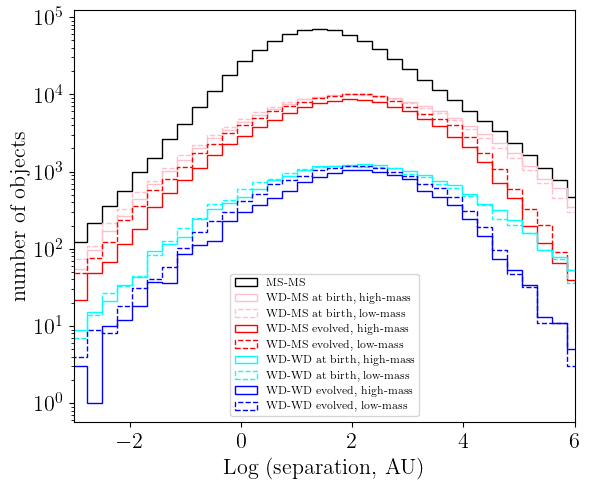

In [41]:
# same as above, but consolidating and changing colors for the publication-quality figures: 
n_bins=50
# this is the median mass of a WD in an WD-MS pair: 
med_mass=np.median(mybin0['fm1'])
print("cutoff WD mass=",med_mass)
fig=plt.figure()
fig.patch.set_facecolor('white')
(n,bins,patches)=plt.hist(np.log10(mybin1['sma']), n_bins, histtype='step', stacked=True, fill=False, linestyle='solid', color='black', label='MS-MS')
# WD-MS
ind0a=(mybin0['fm1']>med_mass)
ind0b=(mybin0['fm1']<=med_mass)
plt.hist(np.log10(mybin0['sma'][ind0a]), bins, histtype='step', stacked=True, fill=False, color='pink', linestyle='solid', label='WD-MS at birth, high-mass')
plt.hist(np.log10(mybin0['sma'][ind0b]), bins, histtype='step', stacked=True, fill=False, color='pink', linestyle='dashed', label='WD-MS at birth, low-mass')
ind0c=(ind0a & (mybin0['fsma']>0))
ind0d=(ind0b & (mybin0['fsma']>0))
plt.hist(np.log10(mybin0['fsma'][ind0c]), bins, histtype='step', stacked=True, fill=False, color='red', linestyle='solid', label='WD-MS evolved, high-mass')
plt.hist(np.log10(mybin0['fsma'][ind0d]), bins, histtype='step', stacked=True, fill=False, color='red', linestyle='dashed', label='WD-MS evolved, low-mass')
# WD-WD
med_mass_pair=np.median(np.sqrt(mybin2['fm1']*mybin2['fm2']))
#ind2a=((mybin2['fm1']>med_mass) | (mybin2['fm2']>med_mass))
ind2a=(np.sqrt(mybin2['fm1']*mybin2['fm2'])>med_mass_pair)
ind2b=np.logical_not(ind2a)
plt.hist(np.log10(mybin2['sma'][ind2a]), bins, histtype='step', stacked=True, fill=False, color='cyan', linestyle='solid', label='WD-WD at birth, high-mass')
plt.hist(np.log10(mybin2['sma'][ind2b]), bins, histtype='step', stacked=True, fill=False, color='cyan', linestyle='dashed', label='WD-WD at birth, low-mass')
ind2c=((mybin2['fsma2']>0) & ind2a)
ind2d=((mybin2['fsma2']>0) & ind2b)
plt.hist(np.log10(mybin2['fsma2'][ind2c]), bins, histtype='step', stacked=True, fill=False, color='blue', linestyle='solid', label='WD-WD evolved, high-mass')
plt.hist(np.log10(mybin2['fsma2'][ind2d]), bins, histtype='step', stacked=True, fill=False, color='blue', linestyle='dashed', label='WD-WD evolved, low-mass')
plt.legend(prop = { "size": 8 }, loc='lower center')
plt.yscale('log')
plt.xlabel('Log (separation, AU)')
plt.ylabel('number of objects')
plt.xlim((-3.,6.))
fig.tight_layout()
plt.savefig('public_evolution_sma_distribution.png')
plt.show()
plt.close()